
# Машинное обучение, DS-поток
## Задание 1.10


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

---


В данном домашнем задании вам предлагается проанализировать и улучшить модель для `Sentiment Analysis`, которую вы обучали на предыдущем семинаре.

Предлагается выполнить следующие пункты:


1. **(2 балла)** Примените стемминг или лемматизацию к датасету. Как поменялось качество? 

2. **(2 балла)** Попробуйте изменить размерность эмбеддинга на сильно большую и сильно меньшую. В качестве размеров эмбеддингов можно взять 30 и 200. Как меняется качество модели? Какая модель более склонна к переобучению и почему?

3. **(2 балла)** Посмотрите на обученнные вами эмбеддинги у модели с маленьким размером эмбеддинга из предыдущего пункта. Для нескольких слов найдите похожие на него по косинусному сходству. 

5. **(2 балла)** Попробуйте рассмотреть фильтры меньших размеров.
 * Рассмотрите фильтры размеров 1, 2, 3
 * Рассмотрите фильтры размеров 1, 2
 
 Сильно ли меняется качество модели для данной задачи? Почему?

6. **(2 балла)** Как можно заметить, у нас не сильно большая тренировочная выборка. Попробуйте сделать аугментацию текста. 

  Один из вариантов: заменять слово на синоним с какой-то вероятностью $p$. То есть с вероятностью $p$ каждое слово будет заменено на некоторый его синоним, а с вероятностью $1 - p$ слово останется как есть.


Для простоты анализа результатов стоит не применять сразу несколько улучшений, а делать их отдельно. В каждом выполняемом пункте постройте кривую лосса как для трейна, так и для валидации.

Нужно использовать те же версии библиотек, что и на семинаре.

In [ ]:
!pip install -U nltk
!pip install -U gensim
!pip install -U torch

!pip uninstall -y torchtext
!pip install 'torchtext<0.9'

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 749 kB 44.9 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 24.1 MB 59.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [ ]:
import numpy as np
import random
import time
import seaborn as sns
from tqdm.notebook import trange, tqdm
from collections import defaultdict
from IPython.display import clear_output

from matplotlib import pyplot as plt

import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer 

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

nltk.download('punkt') # для токенизации текстов и работы с пунктуацией
nltk.download('wordnet') # для графа зависимостей между словами

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sns.set(font_scale=1.2, style='whitegrid')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Зафиксируем random seed для воспроизводимости результатов

In [ ]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Создадим поле для текста и зададим способ токенизации для него, а также создадим поле для метки
отзыва

In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Скачаем данные, представив их в виде трейна, валидации, теста.

In [ ]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 27.1MB/s]
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Вспомогательные функции с семинара. Вы можете их переписать, есть требуется.

In [ ]:
def binary_accuracy(preds, y):
    """
    Возвращает точность модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные метки классов.

    """

    # округляет предсказания до ближайшего integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion, loss_history):
    '''
    Функция для обучения модели на обучающем датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.

    Возвращает среднее значение лосса и среднюю точность во время эпохи.
    Добавляет в массив loss_history значение лоссов по батчам во время эпохи.
    
    '''

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_id, batch in enumerate(iterator):
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss_history.append(epoch_loss / (batch_id + 1))
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.

    Возвращает среднее значение лосса и среднюю точность во время эпохи.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        for batch in iterator:
            # получим предсказания
            predictions = model(batch.text).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    '''
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    '''

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def training_loop(model_instance, n_epochs=15, name_save='tut4-model'):
    '''
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.

    Сохраняет модель, показавшую лучшее значение метрики на валидации, в файл.
    '''

    best_valid_loss = float('inf')
    loss_history_train = []

    history = defaultdict(lambda: defaultdict(list))
    for epoch in range(n_epochs):
        start_time = time.time()
        # обучим одну эпоху на обучающем датасете
        train_loss, train_acc = train(model_instance, train_iterator, optimizer, criterion, loss_history_train)

        # оценим точность модели на тестовом датасете
        valid_loss, valid_acc = evaluate(model_instance, valid_iterator, criterion)

        # посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        history['loss']['val'].append(valid_loss)
        history['acc']['val'].append(valid_acc)

        clear_output(True)
        fig = plt.figure(figsize=(25, 7))
        # отобразим графики loss'а
        plt.subplot(1,3,1)
        plt.plot(loss_history_train,label='train')
        plt.xlabel('номер батча')
        plt.ylabel('значение')
        plt.legend()
        plt.title('Изменение функции потерь')


        #теперь график чисто по эпохам
        plt.subplot(1,3,2)
        plt.title('Изменение binary_accuracy ')
        plt.plot(history['acc']['train'], label='train')
        plt.plot(history['acc']['val'], label='val')
        plt.ylabel('binary_accuracy')
        plt.xlabel('эпоха')
        plt.legend()


        plt.subplot(1,3,3)
        plt.title('Изменение loss ')
        plt.plot(history['loss']['train'], label='train')
        plt.plot(history['loss']['val'], label='val')
        plt.ylabel('значение')
        plt.xlabel('эпоха')
        plt.legend()
        plt.show()

        # если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), name_save+'.pt')
      
        print(f'Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## 0.Начальное приближение из семинара, возьмем самую простую модель, так как она показала наиболее хорошие результаты

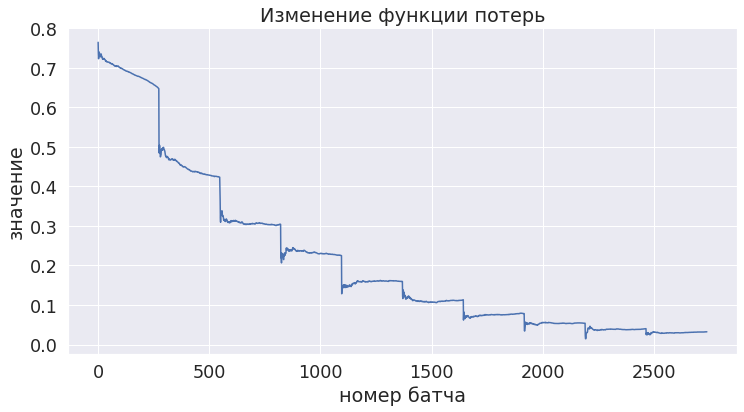

Номер эпохи: 10 | Время обучения эпохи: 0m 24s
	Train Loss: 0.032 | Train Acc: 99.04%
	 Val. Loss: 0.432 |  Val. Acc: 87.12%


In [ ]:
training_loop(model)

Оценим точность модели.

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.334 | Test Acc: 85.71%


## 1. Предобработка данных

Примените стемминг или лемматизацию к train, test и validation датасетам.

*Подсказка.* В `train_data[i].text` лежит текст для $i$-ого объекта. Чтобы не разбираться с созданием нового `torchtext.data.dataset` вы можете перезаписать это поле.

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')  # нужно для модуля nltk.pos_tag

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def get_wordnet_pos(word):
    """ Переводит POS tag в один символ для lemmatize() """
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()

# лемматизация одного слова
word = 'feet'
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

foot


In [ ]:
tmp=train_data[0].text[:10].copy()
tmp

['No',
 'likeable',
 'characters',
 '(',
 'the',
 'lead',
 'is',
 'a',
 'combination',
 'of']

In [ ]:
def lemmatize_data(data):
    for i in trange(len(data)):
        data[i].text=[lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in data[i].text]
    return data

In [ ]:
test_data=lemmatize_data(test_data)
valid_data=lemmatize_data(valid_data)
train_data=lemmatize_data(train_data)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

In [ ]:
train_data[0].text[:10], tmp

(['No',
  'likeable',
  'character',
  '(',
  'the',
  'lead',
  'be',
  'a',
  'combination',
  'of'],
 ['No',
  'likeable',
  'characters',
  '(',
  'the',
  'lead',
  'is',
  'a',
  'combination',
  'of'])

Ограничим словарь для модели, убрав наименее частые слова. 

In [ ]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Зададим модель, аналогичную той, что была на семинаре.

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        '''
        Функция инициализации модели.

        Параметры.
        1) vocab_size — размер словаря,
        2) embedding_dim — размерность векторов-эмбеддингов,
        3) n_filters — количество свёрточных фильтров на каждом слое,
        4) filter_sizes — количество свёрточных слоёв,
        5) output_dim — размер выхода модели,
        6) dropout — вещественное число от 0 до 1, вероятность отключения нейронов,
        7) pad_idx — токен для паддинга.
        '''

        super().__init__()
        # эмбеддинг-слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # свёрточные слои
        self.convs = nn.ModuleList([
          nn.Conv1d(
              in_channels=embedding_dim, out_channels=n_filters, 
              kernel_size=fs,
          ) for fs in filter_sizes
        ])
        # полносвязный слой для получение выхода модели
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        # dropout для регуляризации сети
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        ''' Функция для получения выходов сети по текстам '''
                
        #text.dim = [batch size, sent len]
        #embedded.dim = [batch size, sent len, emb dim]
        embedded = self.embedding(text)
        
        #embedded.dim = [batch size, emb dim, sent len]
        embedded = embedded.permute(0, 2, 1)

        #conved_n.dim = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        conved = [F.relu(conv(embedded)) for conv in self.convs]

        #pooled_n.dim = [batch size, n_filters]  
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #cat.dim = [batch size, n_filters * len(filter_sizes)]
        cat = self.dropout(torch.cat(pooled, dim = 1))   

        return self.fc(cat)

Проинициализируем и обучим модель.

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

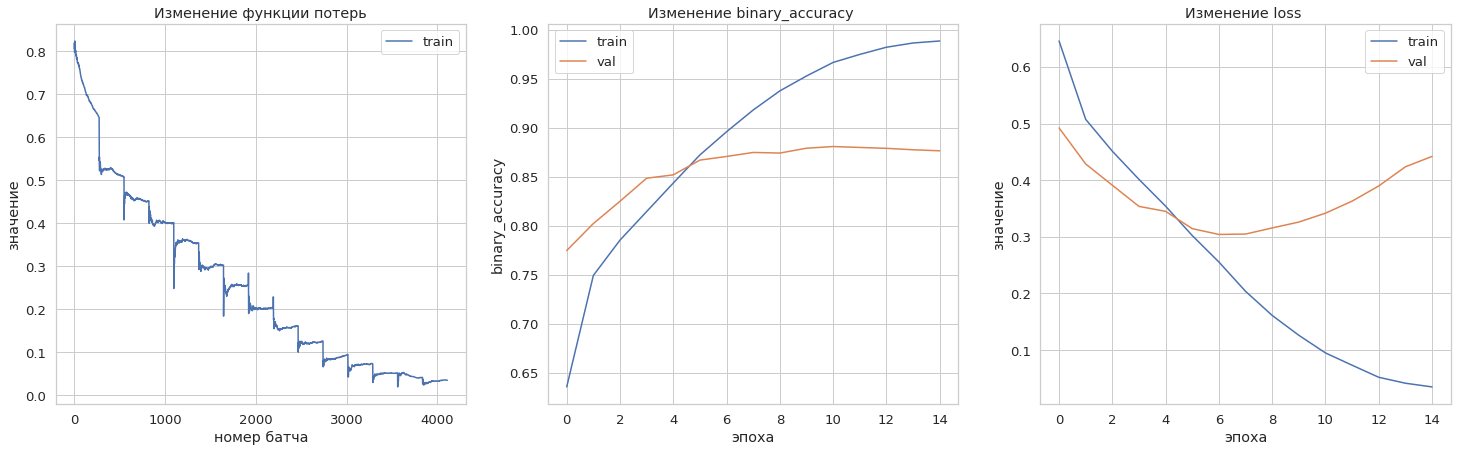

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.442 |  Val. Acc: 87.66%


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

training_loop(model, name_save='task_1_model')

Посчитаем качество модели на тестовой выборке.

In [ ]:
model.load_state_dict(torch.load('task_1_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.308 | Test Acc: 86.81%


**Вывод:** Видим прирост в test acc and val acc, прирост не оч большой порядка 1 процента на теста, на вале 0.5%. Но также мы видим очень большое переобучение нашей модели, причем оно начинается примерно с 6 эпохи. Так что стоило бы добавить sheduler, но его изначально не было, а мы все-таки сравниваем с семинарской, так что было бы нечестно добавлять sheduler.

## 2. Изменение размера эмбеддинга

Уменьшим размер эмбеддингов до 30. Как поменялось качество модели? 

*Замечание.* Если в предыдущем пункте вы перезаписали датасеты, применив к ним стемминг или лемматизацию, то их нужно скачать заново. 

In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Скачаем данные, представив их в виде трейна, валидации, теста.

In [ ]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 30  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

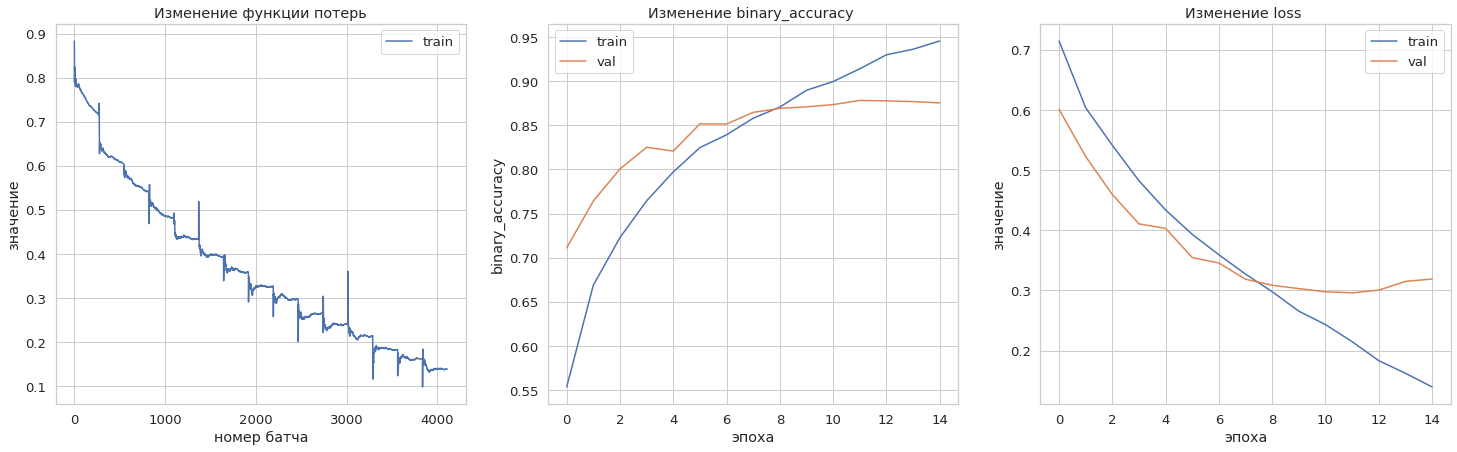

Номер эпохи: 15 | Время обучения эпохи: 0m 18s
	Train Loss: 0.139 | Train Acc: 94.55%
	 Val. Loss: 0.319 |  Val. Acc: 87.54%


In [ ]:
training_loop(model, name_save='task_2_1_model')

In [ ]:
model.load_state_dict(torch.load('task_2_1_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.319 | Test Acc: 86.72%


Теперь  увеличим размер эмбеддингов до 200. Как поменялось качество модели в сравнении с предыдущей? Какая модель более склонна к переобучению и почему?
Сделайте выводы.

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 200  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

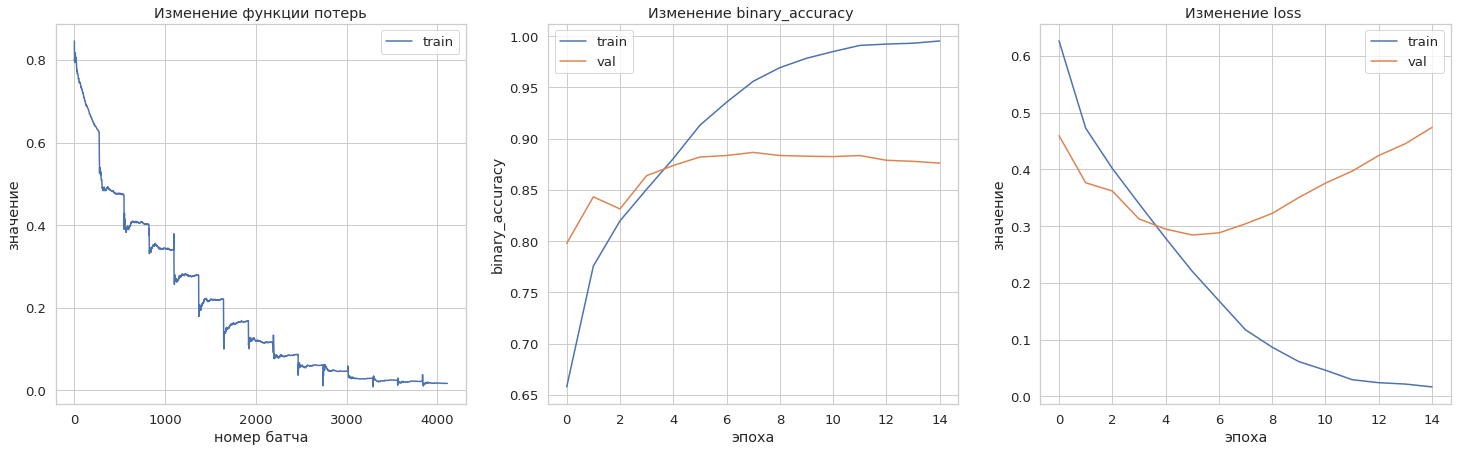

Номер эпохи: 15 | Время обучения эпохи: 0m 52s
	Train Loss: 0.017 | Train Acc: 99.53%
	 Val. Loss: 0.474 |  Val. Acc: 87.61%


In [ ]:
training_loop(model, name_save='task_2_2_model')

In [ ]:
model.load_state_dict(torch.load('task_2_2_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.287 | Test Acc: 88.04%


**Вывод:** в данном случае работает лучше, где у нас очень большая размерность векторов-эмбеддингов(200), на тесте на 1.5% лучше acc, на val acc разница почти незаметна. Теперь насчет переобучения:там где большая размерность векторов-эмбеддингов переобучение начинается намного раньше (примерно 4 эпохи), в то время где маленькая размерность переобучение уже наблюдается примерно около 8 эпохи. Также хорошо видно, что где большая размерность у нас модель вообще полностью переобучилась, так как acc train дошел до 1.

## 3. Нахождение близких слов по эмбеддингам.
Напишите функцию, считающую cosine similarity между двумя векторами.

https://en.wikipedia.org/wiki/Cosine_similarity

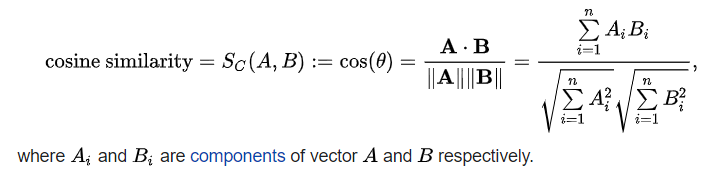

In [ ]:
def cosine_similarity(a, b):
  a=np.array(a)
  b=np.array(b)
  numerator=np.sum(np.multiply(a,b))
  denominator=np.sqrt(np.sum(a**2))*np.sqrt(np.sum(b**2))
  return numerator/denominator

Напишите функцию, которая принимает на вход слово word и $k$ и возвращает $k$ наиболее похожих на word слов. 

Эмбеддинги для каждого слова должны быть получены с помощью матрицы эмбеддингов из Embedding слоя вашей модели. В качестве модели возьмите модель из предыдущего пункта с маленьким размером эмбеддинга. 

Чтобы по слову получить его индекс в словаре и обратно можно воспользоваться аттрибутами нашего словаря: `TEXT.vocab.stoi` и `TEXT.vocab.atoi`.


In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
dict_word_number=TEXT.vocab.stoi
dict_number_word = {v: k for k, v in dict_word_number.items()}#так как в словаре у нас биекция

In [ ]:
def find_most_similar(word, k):
  number=dict_word_number[word]
  word_embedding=model.embedding.weight.data[number]

  res={k: cosine_similarity(word_embedding,model.embedding.weight.data[v]) for k, v in dict_word_number.items()}
  res=sorted(list(res.items()), key = lambda x:x[1], reverse=True)
  res=np.array(res)

  #теперь надо найти k самых лучших
  res=res[(res[:,1]!='nan') & (res[:,0]!=word)]
  return res[:k],res[:k][:,0]

Выберите несколько слов из словаря и посмотрите на их ближайшие по эмбеддингу 5 слов.

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 30  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model.load_state_dict(torch.load('task_2_1_model.pt'))

<All keys matched successfully>

In [ ]:
find_most_similar('great', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


(array([['delight', '0.66617894'],
        ['Steve', '0.6474709'],
        ['Leoni', '0.6324273'],
        ['Red', '0.6237637'],
        ['specialized', '0.61120206']], dtype='<U32'),
 array(['delight', 'Steve', 'Leoni', 'Red', 'specialized'], dtype='<U32'))

In [ ]:
find_most_similar('drama', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


(array([['Napier', '0.65087664'],
        ['breaks', '0.6445972'],
        ['shattered', '0.5924877'],
        ['say', '0.591518'],
        ['turf', '0.5883314']], dtype='<U32'),
 array(['Napier', 'breaks', 'shattered', 'say', 'turf'], dtype='<U32'))

In [ ]:
find_most_similar('wife', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


(array([['Jaffa', '0.6309379'],
        ['Shadows', '0.6184371'],
        ['undergoes', '0.6153781'],
        ['Sayonara', '0.6049641'],
        ['SETH', '0.6029307']], dtype='<U32'),
 array(['Jaffa', 'Shadows', 'undergoes', 'Sayonara', 'SETH'], dtype='<U32'))

In [ ]:
find_most_similar('science', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


(array([['nun', '0.72822607'],
        ['embody', '0.6622892'],
        ['exuberance', '0.63960195'],
        ['1.<br', '0.6321448'],
        ['perils', '0.6157056']], dtype='<U32'),
 array(['nun', 'embody', 'exuberance', '1.<br', 'perils'], dtype='<U32'))

**Вывод:**я тут в перечне самых похожих слов я удалял само число, так как оно имеет косинусную меру 1.  На самом деле мы получили довольно странный результат, часть слов это синонимы, если посмотрим перевод, например delight(восторг) синоним к great, но остальные слова уже не являются такими похожими, но так как у нас данные про кино, возможно в словосочетаниях часто эти слова похожи по смыслу в употрблении, аналогично наука и драма. Насчет жены большиснство похожих слов какие-то имена, видимо имена жен в фильмах,

## 4. Эксперементы со свёртками.

In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Скачаем данные, представив их в виде трейна, валидации, теста.

In [ ]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Обучите модель с фильтрами меньших размеров: 1, 2 и 3. Измерьте ее качество.

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [1, 2, 3]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

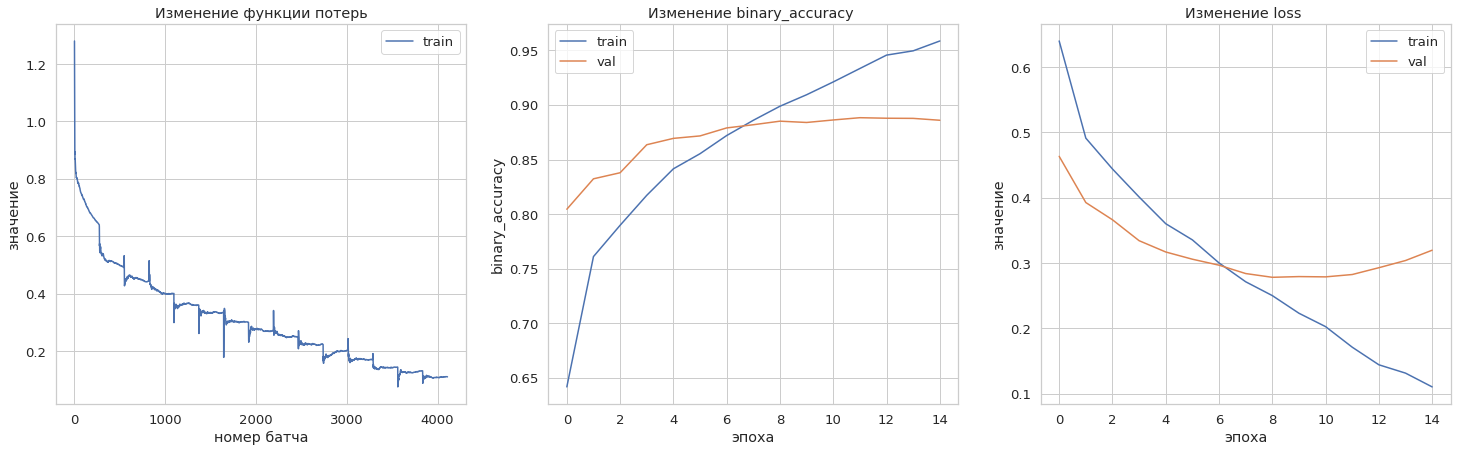

Номер эпохи: 15 | Время обучения эпохи: 0m 24s
	Train Loss: 0.111 | Train Acc: 95.85%
	 Val. Loss: 0.320 |  Val. Acc: 88.59%


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)
training_loop(model, name_save='task_4_1_model')

In [ ]:
model.load_state_dict(torch.load('task_4_1_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.283 | Test Acc: 88.13%


Теперь рассмотрим лишь фильтры размера 1 и 2.

In [ ]:
INPUT_DIM = len(TEXT.vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [1, 2]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

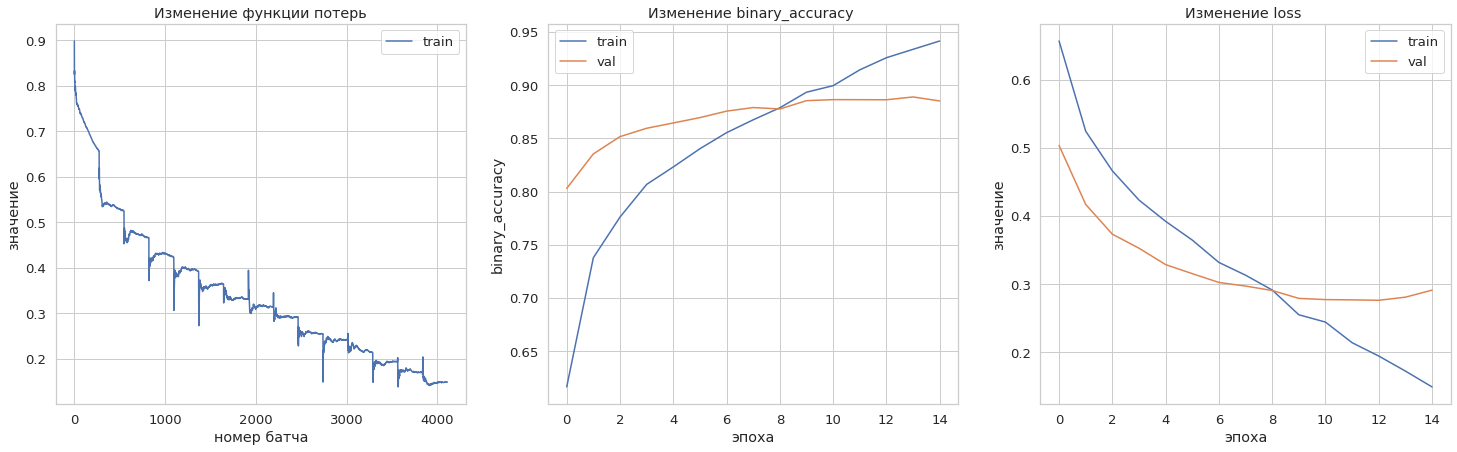

Номер эпохи: 15 | Время обучения эпохи: 0m 17s
	Train Loss: 0.149 | Train Acc: 94.15%
	 Val. Loss: 0.291 |  Val. Acc: 88.52%


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)
training_loop(model, name_save='task_4_2_model')

In [ ]:
model.load_state_dict(torch.load('task_4_2_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.292 | Test Acc: 87.90%


Сильно ли меняется качество модели для данной задачи? Почему?

**Вывод:**видим, что 2 способ оказался слегка похуже, на тесте 0.2%, на val разница порядка одной десятой. Но при этом важно отметить, что во 2 случае переобучение наступает на 2 эпохи попозже, чем в 1 случае и оно не такое сильное. Но давайте обсудим, почему 1 способ дал улучшение по сравнению с начальными данными и 2 способом. В нашей модели в конце мы делаем max_pool1d, когда мы уменьшаем размер фильтров, то в конце работы нашей сетки до max_pool1d мы получаем более большой размеры, то есть мы захватываем больше информации, тогда max_pool1d обрабатывает побольше информации. Если мы делаем слишком маленький размер фильтров, то ситуация обратная. 1 способм уменьшили размер фильтров по сравнению с базовым решением, получили более большой acc, так как мы стали видеть чуть меньше информации, то есть стали более точечно оценивать информацию(не распыляемся больше), но при этом еще не слишком "узко" смотрим. А вот во 2 способе мы начинаем уже слишком "узко" смотреть, что приводит к ухудшению качества метрики

## 5. Аугментация данных.

Попробуйте сделать аугментацию текста. 

Замените слово на синоним с некоторой вероятностью $p$. То есть с вероятностью $p$ каждое слово будет заменено на некоторый его синоним, а с вероятностью $1 - p$ слово останется как есть.

Обучите модель на таких данных и посмотрите на качество.

In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Скачаем данные, представив их в виде трейна, валидации, теста.

In [ ]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
train_data_text=[[] for i in range(len(train_data))]
for i in trange(len(train_data)):
  one_text=[word for j,word in enumerate(train_data[i].text)]
  train_data_text[i]=one_text

  0%|          | 0/17500 [00:00<?, ?it/s]

In [ ]:
def one_synonym(word, top_k=2):
  all=[]
  for synset in wordnet.synsets(word):
      all+=synset.lemma_names()[:top_k]
  return np.random.choice(all,1)[0] if len(all)>0 else word

In [ ]:
def text_augmentation(train_data,train_data_text,p=0.3):
  #train_data_text(list)
  for i in trange(len(train_data_text)):
        status=np.random.binomial(1,p,size=len(train_data_text[i]))
        train_data[i].text=[one_synonym(word) if status[j]==1 else word for j,word in enumerate(train_data_text[i])]
  return train_data


In [ ]:
def counting_output(p=0.3, name_path='model'):
  global train_data
  train_data=text_augmentation(train_data,train_data_text, p)

  MAX_VOCAB_SIZE = 25000
  TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
  LABEL.build_vocab(train_data)

  BATCH_SIZE = 64
  global train_iterator,valid_iterator,test_iterator
  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, valid_data, test_data), 
      batch_size = BATCH_SIZE, 
      device = device
  )
  INPUT_DIM = len(TEXT.vocab)  # размер словаря
  EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
  N_FILTERS = 100  # количество свёрточных фильтров
  FILTER_SIZES = [3, 4, 5]  # размеры фильтров на каждом уровне
  OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
  DROPOUT = 0.5  # вероятность dropout
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # id токена для паддинга

  global optimizer,criterion,model
  model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

  optimizer = torch.optim.Adam(model.parameters())
  criterion = nn.BCEWithLogitsLoss()
  model = model.to(device)
  criterion = criterion.to(device)
  training_loop(model, name_save=name_path)

  model.load_state_dict(torch.load(name_path+'.pt'))
  test_loss, test_acc = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

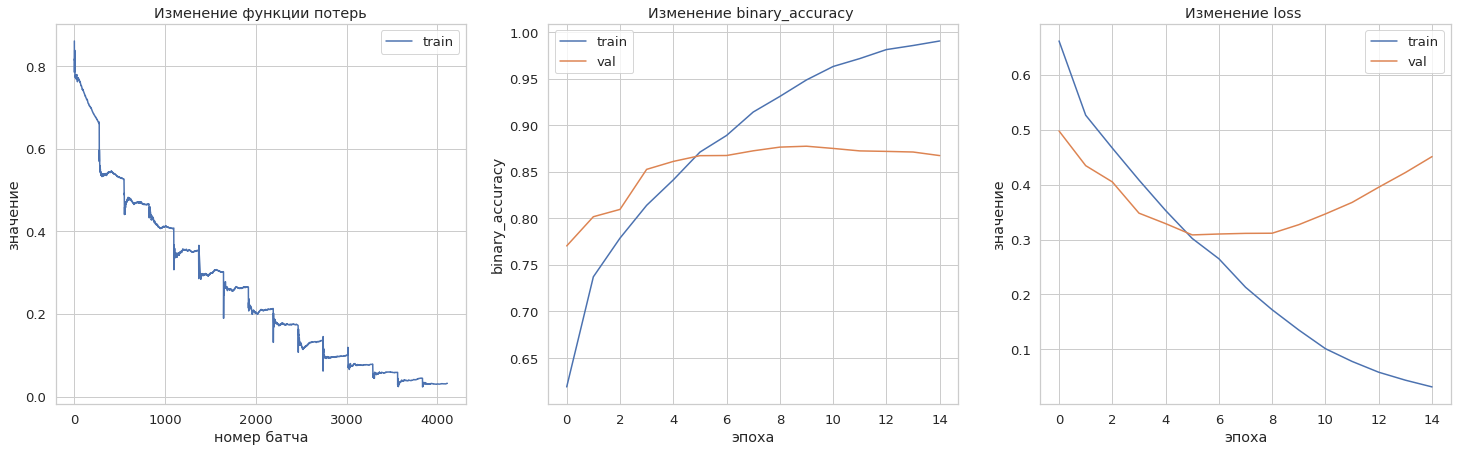

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.032 | Train Acc: 99.04%
	 Val. Loss: 0.451 |  Val. Acc: 86.73%
Test Loss: 0.309 | Test Acc: 86.89%


In [ ]:
counting_output(0.1,'task_5_p_0.1')

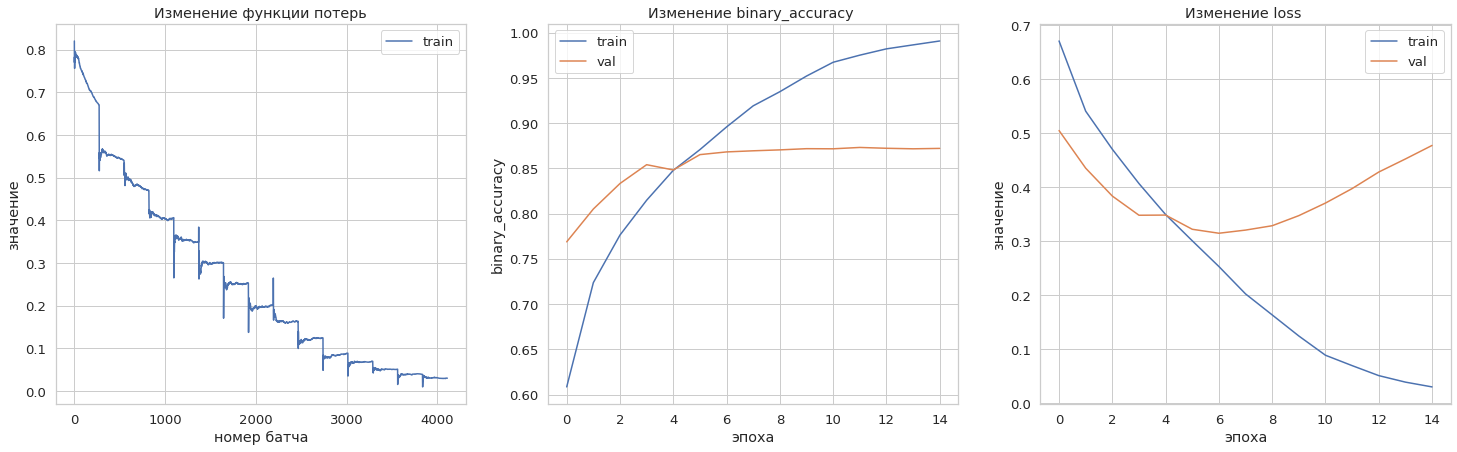

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.030 | Train Acc: 99.09%
	 Val. Loss: 0.477 |  Val. Acc: 87.22%
Test Loss: 0.316 | Test Acc: 86.25%


In [ ]:
counting_output(0.2,'task_5_p_0.2')

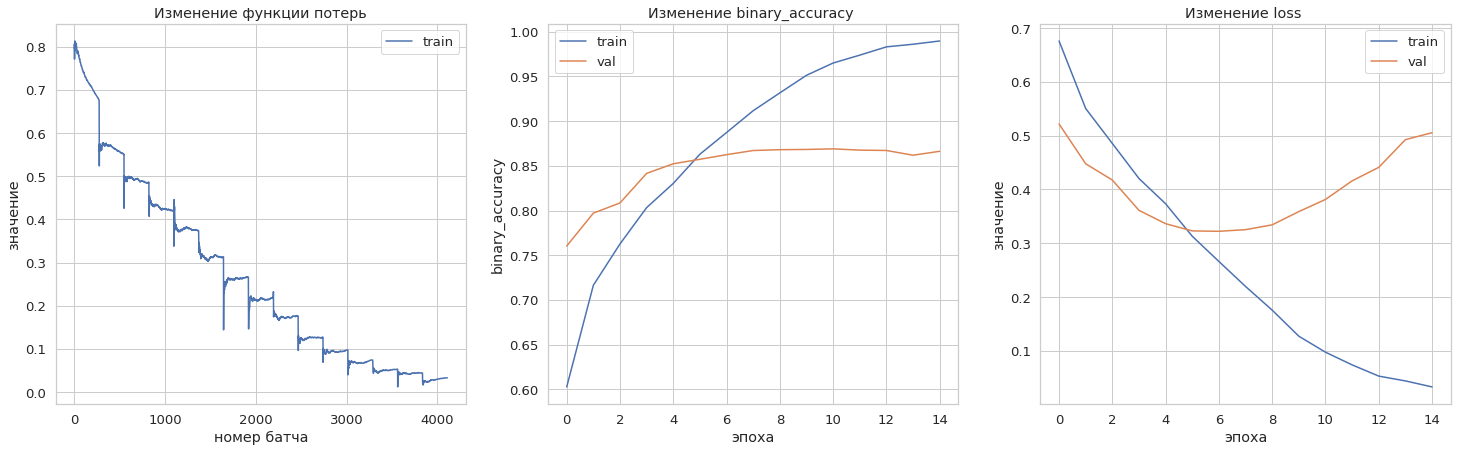

Номер эпохи: 15 | Время обучения эпохи: 0m 34s
	Train Loss: 0.033 | Train Acc: 98.95%
	 Val. Loss: 0.505 |  Val. Acc: 86.62%
Test Loss: 0.318 | Test Acc: 86.36%


In [ ]:
counting_output(0.3,'task_5_p_0.3')

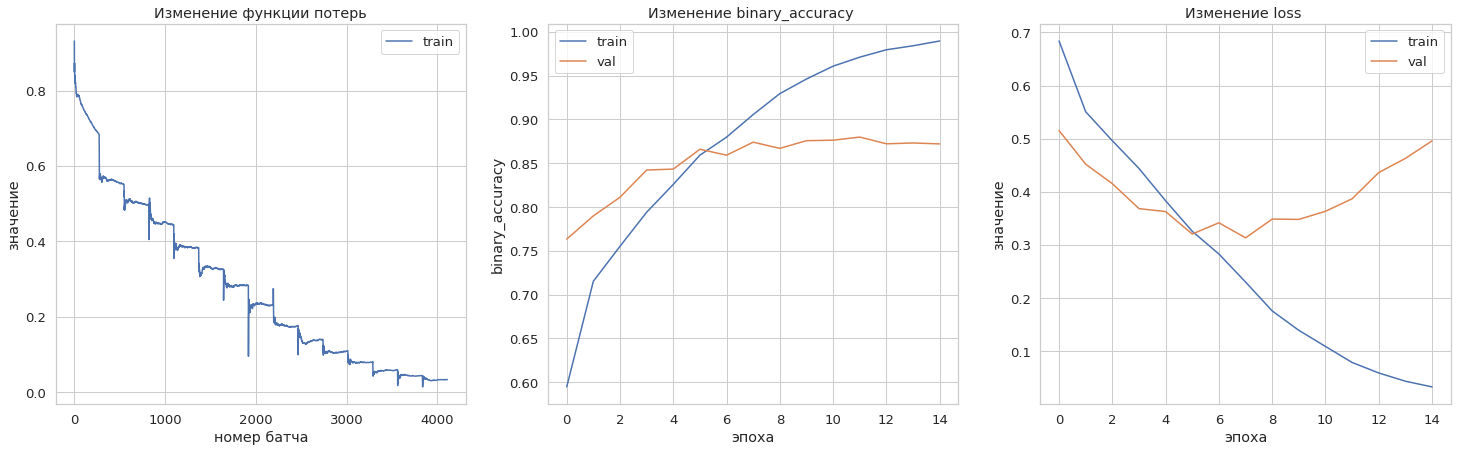

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.033 | Train Acc: 98.97%
	 Val. Loss: 0.496 |  Val. Acc: 87.21%
Test Loss: 0.318 | Test Acc: 86.74%


In [ ]:
counting_output(0.4,'task_5_p_0.4')

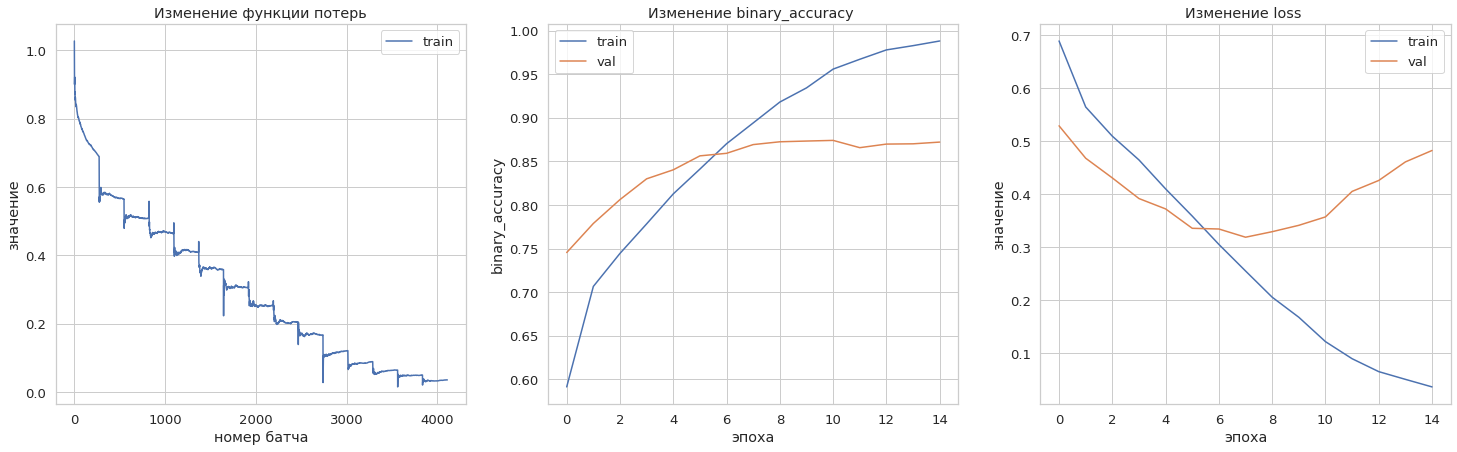

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.036 | Train Acc: 98.83%
	 Val. Loss: 0.482 |  Val. Acc: 87.22%
Test Loss: 0.325 | Test Acc: 86.09%


In [ ]:
counting_output(0.5,'task_5_p_0.5')

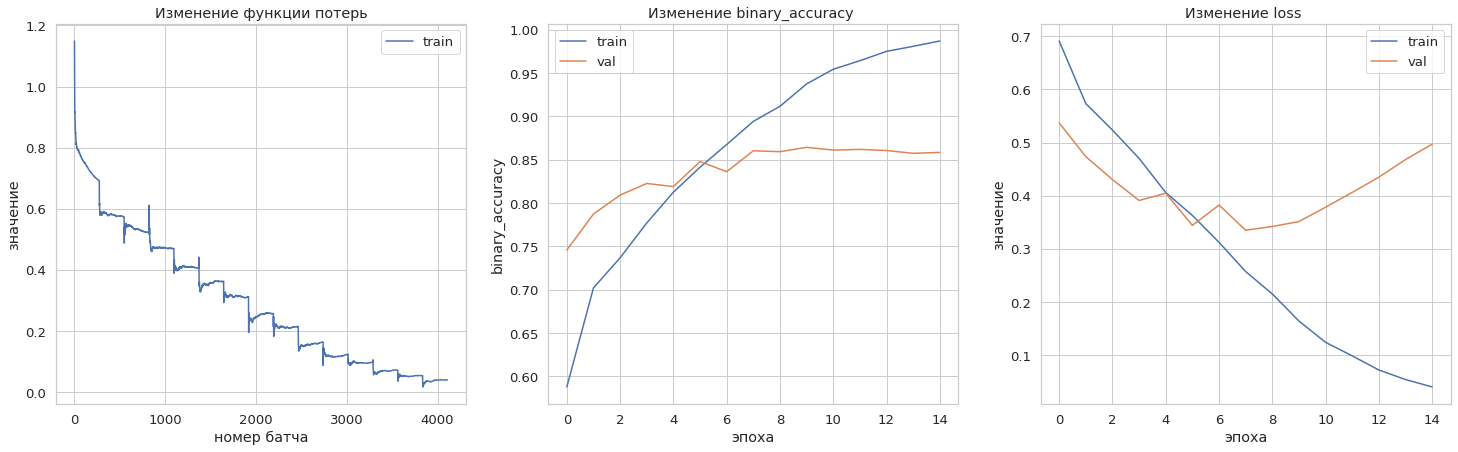

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.040 | Train Acc: 98.70%
	 Val. Loss: 0.497 |  Val. Acc: 85.85%
Test Loss: 0.339 | Test Acc: 85.65%


In [ ]:
counting_output(0.6,'task_5_p_0.6')

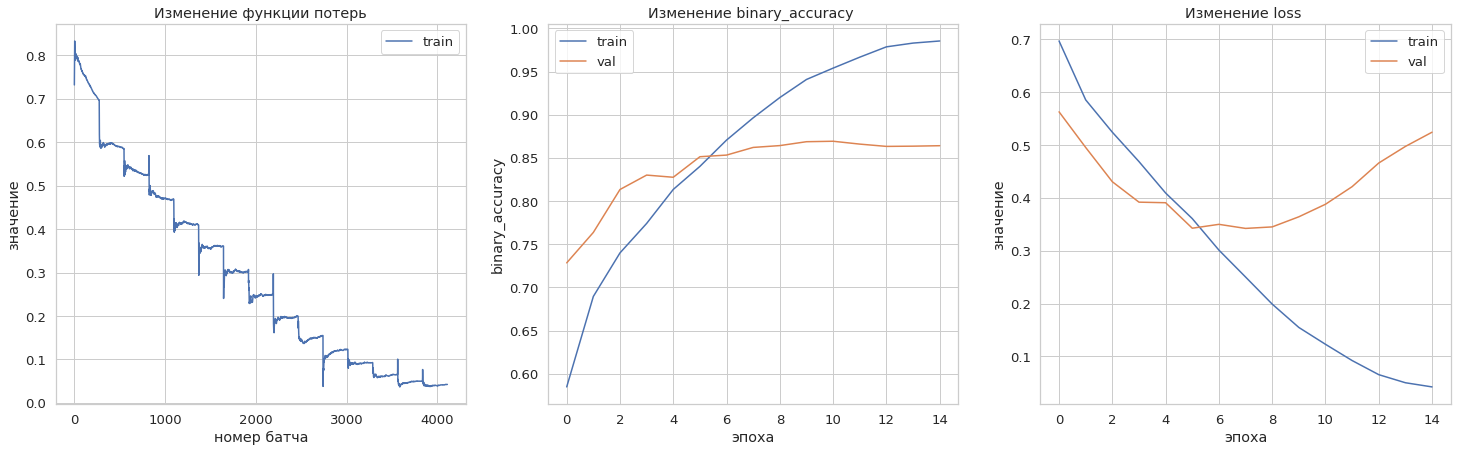

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.042 | Train Acc: 98.54%
	 Val. Loss: 0.524 |  Val. Acc: 86.41%
Test Loss: 0.353 | Test Acc: 85.08%


In [ ]:
counting_output(0.7,'task_5_p_0.7')

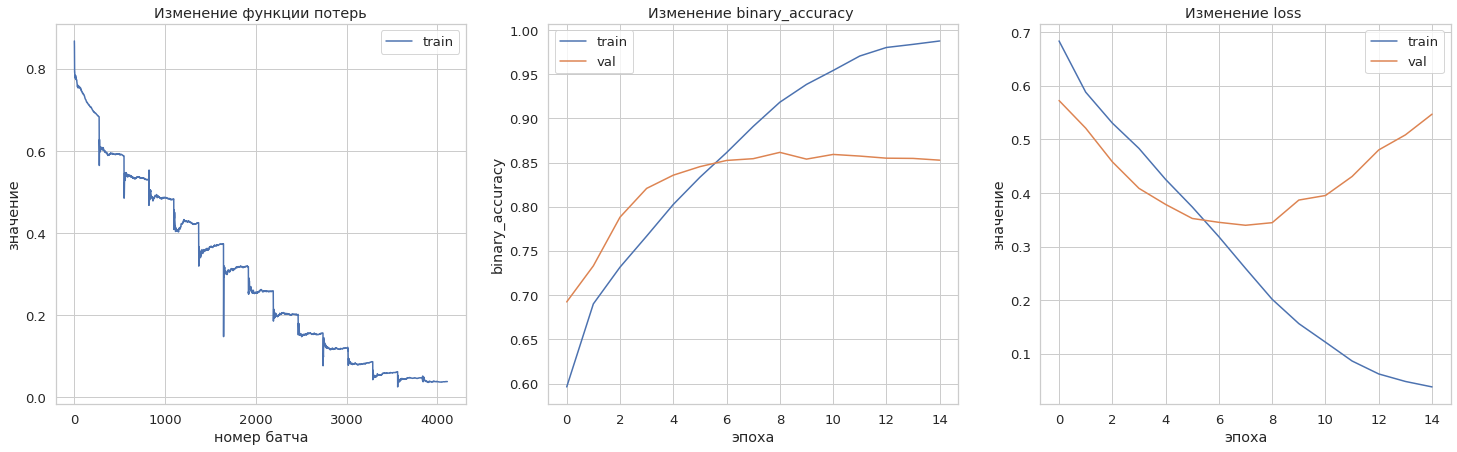

Номер эпохи: 15 | Время обучения эпохи: 0m 33s
	Train Loss: 0.038 | Train Acc: 98.76%
	 Val. Loss: 0.547 |  Val. Acc: 85.28%
Test Loss: 0.353 | Test Acc: 85.05%


In [ ]:
counting_output(0.8,'task_5_p_0.8')

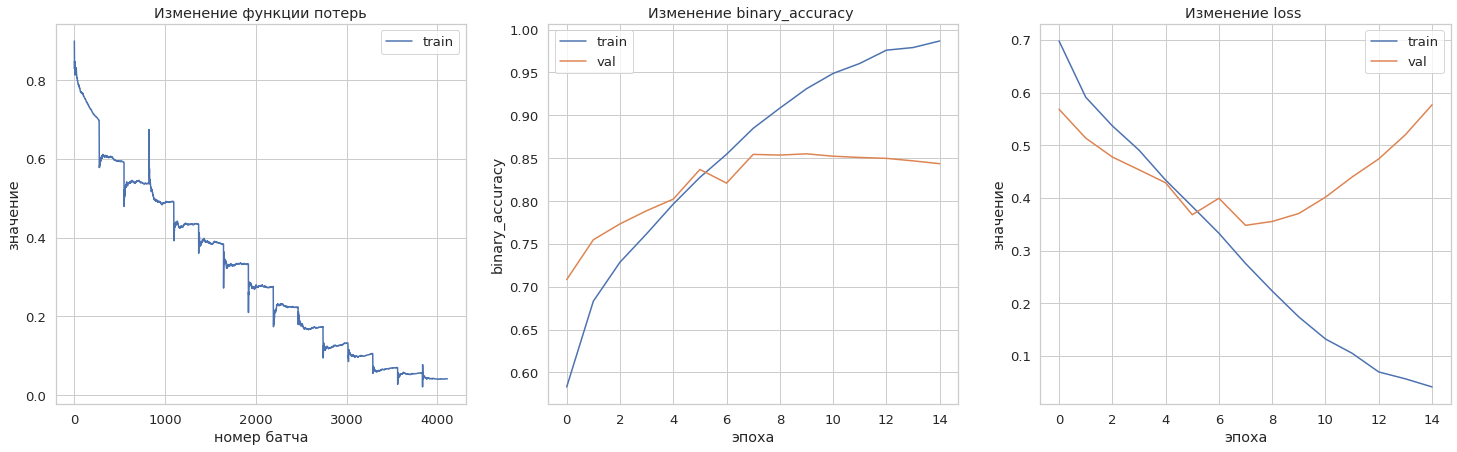

Номер эпохи: 15 | Время обучения эпохи: 0m 34s
	Train Loss: 0.041 | Train Acc: 98.68%
	 Val. Loss: 0.577 |  Val. Acc: 84.36%
Test Loss: 0.364 | Test Acc: 84.16%


In [ ]:
counting_output(0.9,'task_5_p_0.9')

**Вывод:**самые лучшие результаты мы получили при p=0.1 и 0.4, но на самом деле все графики очень схожи, на самом деле это связано с тем,что у каждого слова есть огромный перечень синонимов, но если мы будем брать радомный среди всего огромного кол-ва синономов, то есть огромный шанс того, что по итогу мы не будем использовать это слово так как оно редкое, так что нам надо искусственно ограничить перечень синонимов для каждой группы. Но  в любом случае это делает нашу модель более гибкой, но мы должны заменять не каждое слово на синоним. Но это еще один хороший способ для улучшения метрики нашей модели и делать ее более гибкой, так как в тесте могут встречаться слова, которых не было в тесте, но которые одинаковые по смыслу. Но оно не дает такие хорошие результаты, как другие способы, а часто только делает их хуже, так что видимо надо иметь словарь синономов и их частоту, а также частоту по train и уже отталкиваясь от этого, ограничывать выборку синонимов.